In [1]:
import ipyparallel as ipp
import math

In [2]:
c = ipp.Client()

In [3]:
c.ids

[0, 1, 2, 3]

In [4]:
dview = c[:] 

In [5]:
# In IPython, these operations are called push() 
# (sending an object to the engines) 
# and pull() (getting an object from the engines).
dview.push(dict(a=1.03234, b=3453))

<AsyncResult: _push>

In [6]:
dview.pull('a', block=True)

[1.03234, 1.03234, 1.03234, 1.03234]

In [7]:
dview.pull(['a', 'b'], block=True)

[[1.03234, 3453], [1.03234, 3453], [1.03234, 3453], [1.03234, 3453]]

In [8]:
dview.pull('b', targets=0, block=True)

3453

In [9]:
for i in range(4):
    dview.push(dict(a=i, b=i ** 2 + 1), targets=i)

In [10]:
dview.pull('a', block=True)

[0, 1, 2, 3]

In [11]:
dview.pull('b', block=True)

[1, 2, 5, 10]

In [12]:
# scatter() is from the interactive IPython session to the engines 
dview.scatter('c', range(28))

<AsyncResult: scatter>

In [13]:
dview['c']

[range(0, 7), range(7, 14), range(14, 21), range(21, 28)]

In [14]:
# gather() is from the engines back to the interactive IPython session.
ar = dview.gather('c', block=True)

In [15]:
print(ar[1][2])

9


In [16]:
# @remote, which calls the function on every engine of a view.
@dview.remote(block=True)
def getpid():
    import os
    return os.getpid()

In [17]:
getpid()

[9380, 25412, 17108, 10624]

In [18]:
# Hello world ! Again
n = len(c)
for i in range(n):
    dview.push(dict(npes=n, myrank=i), targets=i)
    
@dview.remote(block=True)
def hello():
    return "Hello world from %i out of %i !" %(myrank, npes)

hello()

['Hello world from 0 out of 4 !',
 'Hello world from 1 out of 4 !',
 'Hello world from 2 out of 4 !',
 'Hello world from 3 out of 4 !']

In [19]:
# A bit on dictionary
number = {'three': 3, 'ninety': 90, 'two': 2, 'one': 1}
print(number)
dview.push(number)

print(type(number))


@dview.remote(block=True)
def dict_num():
    return one, ninety

dict_num()

{'three': 3, 'ninety': 90, 'two': 2, 'one': 1}
<class 'dict'>


[(1, 90), (1, 90), (1, 90), (1, 90)]

In [20]:
# We are adding 'c' which we need to scatter
# among all engines before we call this function.
@dview.remote(block=True)
def local_sum():
    return sum(c)


# mu is the mean
@dview.remote(block=True)
def local_var_sum_arg(mu):
    l_sum = 0
    for i in c:
        l_sum += (i - mu)**2
    return l_sum


In [21]:
l_sum = local_sum()
print('Partial sum', l_sum)
g_sum = sum(l_sum)

print('Gobal sum', g_sum)

gmu = g_sum/28
print('Mean', gmu)

l_sum = local_var_sum_arg(gmu)
print('Partial variance sum', l_sum)
g_sum  = sum(l_sum)
g_var = math.sqrt(g_sum/28)
print('Variance = ', g_var)


Partial sum [21, 70, 119, 168]
Gobal sum 378
Mean 13.5
Partial variance sum [799.75, 113.75, 113.75, 799.75]
Variance =  8.077747210701755


In [22]:
# How about synchronization ?
@dview.remote(block=False)
def eng_wait():
    import time
    time.sleep(myrank*10)
    a = myrank 
    return a

In [23]:
dview.pull('a', block=True)

[0, 1, 2, 3]

In [24]:
ar = eng_wait()

In [25]:
ar.wait()

True

In [26]:
import numpy as np
import time
A = np.random.random((640,48))
# 640x48
A.size

30720

In [27]:
@dview.parallel(block=True)
def pmul(A,B):
    return A*B

In [28]:
t1 = time.time()
C_local = A*A
t2 = time.time()
print('serial run time: ' + str(t2-t1) + ' seconds')

serial run time: 0.0 seconds


In [29]:
t1 = time.time()
C_remote = pmul(A,A)
t2 = time.time()
print('parallel run time: ' + str(t2-t1) + ' seconds')

parallel run time: 0.01632237434387207 seconds


In [30]:
dview.block=False
dview.scatter('x',range(32000))

t1 = time.time()
%px y = sum(x)
%px for i in range(10 ** 8): i+=1
    
y = dview.gather('y')
global_sum = sum(y)

t2 = time.time()
print(global_sum)

print('parallel run time: ' + str(t2-t1) + ' seconds')

511984000
parallel run time: 12.908416509628296 seconds


In [31]:
xx = list(range(32000))
# print(x)
t1 = time.time()
for i in range(4* 10 ** 8): i+=1
global_sum =  sum(xx)
# print(y)
t2 = time.time()
print(global_sum)
print('serial run time: ' + str(t2-t1) + ' seconds')

511984000
serial run time: 29.158934831619263 seconds


In [32]:
with c[:].sync_imports():
    import numpy 

importing numpy on engine(s)


In [33]:
%px print('Hello world!')

[stdout:0] Hello world!
[stdout:1] Hello world!
[stdout:2] Hello world!
[stdout:3] Hello world!


In [34]:
%px a = numpy.random.rand(2,2)

In [35]:
%px print(a)
%px numpy.linalg.eigvals(a)   

[stdout:0] 
[[0.42779427 0.83440024]
 [0.78218275 0.30065563]]
[stdout:1] 
[[0.42862407 0.44256371]
 [0.4952116  0.42952997]]
[stdout:2] 
[[0.35026195 0.78519812]
 [0.34888439 0.39908556]]
[stdout:3] 
[[0.91330415 0.86295018]
 [0.28620637 0.27678103]]


Out[0:6]: array([ 1.17459186, -0.44614196])

Out[1:6]: array([-0.03907134,  0.89722538])

Out[2:6]: array([-0.14929122,  0.89863874])

Out[3:6]: array([1.18518855, 0.00489662])

In [36]:
# The %pylab inline specifies that figures should be   
# shown inline, directly in the notebook. 
%px %pylab inline

[stdout:0] Populating the interactive namespace from numpy and matplotlib
[stdout:1] Populating the interactive namespace from numpy and matplotlib
[stdout:2] Populating the interactive namespace from numpy and matplotlib
[stdout:3] Populating the interactive namespace from numpy and matplotlib


In [37]:
%px x = np.linspace(0, 20, 1000)  
# 1000 evenly-spaced values from 0 to 20
%px y = np.sin(x)

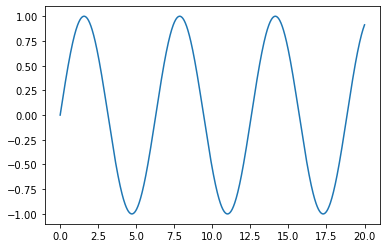

Out[0:10]: [<matplotlib.lines.Line2D at 0x1052d90ef28>]

In [38]:
%%px --target 0 
pylab.plot(x, y)

In [39]:
%%px --targets ::2
print("I am even")

[stdout:0] I am even
[stdout:2] I am even


In [40]:
%%px --noblock
import time
time.sleep(1)
time.time()

<AsyncResult: execute>

In [41]:
%pxresult

Out[0:12]: 1610425930.3477736

Out[1:10]: 1610425930.3491056

Out[2:11]: 1610425930.3498662

Out[3:10]: 1610425930.3498662